In [1]:
from imports import *
from information_conditions import Information_Conditions
from base_ecopg import *
from helper_functions import *
from simulation_and_results_functions import *

In [23]:
mae_ecopg_social = create_mae_ecopg_for_given_mode_POstratAC_expanded("social", discount_factor= 0.995, m= -6.5)
mae_ecopg_complete = create_mae_ecopg_for_given_mode_POstratAC_expanded("complete", discount_factor= 0.995, m= -6.5)

In [11]:
def add_random_degraded_state_policy_complete(starting_point):
     for i in [0, 2, 4, 6]:
        random_block = np.random.rand(2)
        stacked_random_block = np.stack([random_block, 1-random_block],axis = -1)
        starting_point = np.insert(starting_point, i, stacked_random_block, axis = 1)

     return starting_point


def add_random_degraded_state_ecological(starting_point):
     for i in [0]:
        random_block = np.random.rand(2)
        stacked_random_block = np.stack([random_block, 1-random_block],axis = -1)
        starting_point = np.insert(starting_point, i, stacked_random_block, axis = 1)

     return starting_point

In [12]:
def generate_random_initial_conditions_around_point(mae, test_point, num_samples, perturbation_size, mode):
    random_initial_conditions = lhs_sampling(mae.Q, num_samples, mae.N)
    # if  mode == 'ecological':
    #     random_initial_conditions_around_point = [(add_random_degraded_state_ecological(test_point) + perturbation_size*sample)/(1 + perturbation_size) for sample in random_initial_conditions]
    # elif mode == 'complete':
    #     random_initial_conditions_around_point = [(add_random_degraded_state_policy_complete(test_point) + perturbation_size*sample)/(1 + perturbation_size) for sample in random_initial_conditions]
    # if mode ==  'none' or  mode == 'social':
    random_initial_conditions_around_point = [(test_point + perturbation_size*sample)/(1 + perturbation_size) for sample in random_initial_conditions]
    return random_initial_conditions_around_point


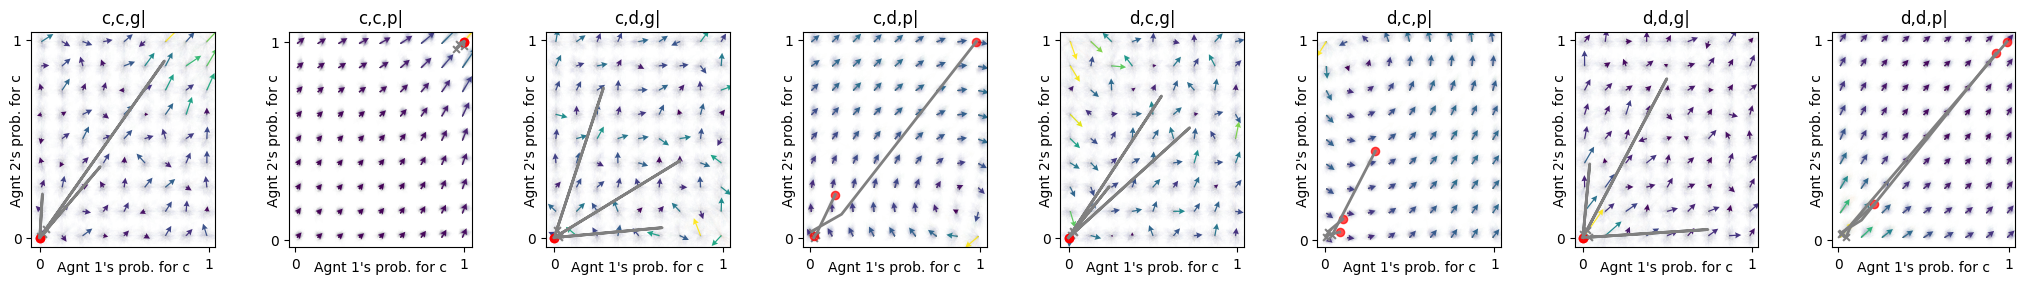

In [29]:
agent_1_strategy = [1,0,0,0]
agent_2_strategy = [1,0,0,0]


agent_1_strategy = [[x, 1-x] for x in agent_1_strategy]
agent_2_strategy = [[x, 1-x] for x in agent_2_strategy]

starting_point = np.array([agent_1_strategy, agent_2_strategy])

starting_point_complete = add_random_degraded_state_policy_complete(starting_point.copy())

random_initial_conditions_around_point = generate_random_initial_conditions_around_point(mae_ecopg_complete, starting_point_complete, 3, 0.05, 'social')

results_list = []
for initial_condition in random_initial_conditions_around_point:
    result = run_simulation_for_initial_condition_with_traj(
            mae = mae_ecopg_complete, 
            initial_condition = initial_condition,
            make_degraded_state_cooperation_probablity_zero_at_end= True,
            make_degraded_state_obsdist_zero_at_end= True
        )
    results_list.append(result)

final_points = [result['final_point'] for result in results_list]


make_plots(mae_ecopg_complete.env, mae_ecopg_complete, results_list)


('ALL D', 'other')
Classified final points: [('ALL D', 'GT'), ('other', 'other'), ('other', 'ALL D'), ('other', 'ALL D'), ('ALL D', 'ALL D')]


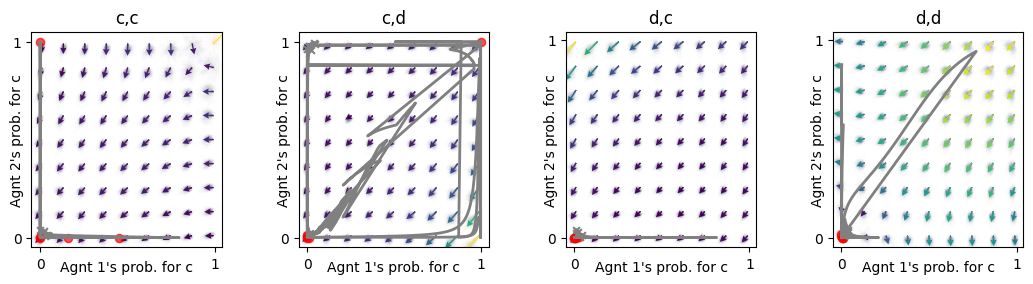

In [ ]:
information_condition_instance_both_state_and_action = Information_Conditions(ecopg, mode= "both_state_and_action_information")
mae_ecopg_both_state_and_action = POstratAC(env=information_condition_instance_both_state_and_action, learning_rates=0.05, discount_factors= 0.98)

agent_1_strategy = [0,0,0,0]
agent_2_strategy = [0,0,0,0]

for i in [0, 2, 4, 6]:
    agent_1_strategy.insert(i, 0.5)
    agent_2_strategy.insert(i, 0.5)

agent_1_strategy = [[x, 1-x] for x in agent_1_strategy]
agent_2_strategy = [[x, 1-x] for x in agent_2_strategy]

starting_point = np.array([agent_1_strategy, agent_2_strategy])

print(classify_final_point(starting_point))

random_initial_conditions_around_point = generate_random_initial_conditions_around_point(mae_ecopg_only_action, starting_point, 5, 0.05)

results_list = []
for initial_condition in random_initial_conditions_around_point:
    result = run_simulation_for_initial_condition_with_traj(
            mae = mae_ecopg_only_action, 
            initial_condition = initial_condition,
            make_degraded_state_cooperation_probablity_zero_at_end= False,
            make_degraded_state_obsdist_zero_at_end= False
        )  
    results_list.append(result)

final_points = [result['final_point'] for result in results_list]


classifed_points = [classify_final_point(final_point) for final_point in final_points]
print("Classified final points:", classifed_points)

make_plots(information_condition_instance_only_action, mae_ecopg_only_action, results_list)


In [ ]:
# generate_random_initial_conditions_around_point(mae_ecopg_both_state_and_action, starting_point, 3, 0.05, "both_state_and_action_information")

In [37]:
def check_for_stability(final_point, mode):
    
    stability = None

    mae =   create_mae_ecopg_for_given_mode_POstratAC(mode)

    random_initial_conditions_around_point = generate_random_initial_conditions_around_point(mae, final_point, 3, 0.05, mode)
    results_list = []
    for initial_condition in random_initial_conditions_around_point:
        result = run_simulation_for_initial_condition_with_traj(
                mae = mae, 
                initial_condition = initial_condition,
                make_degraded_state_cooperation_probablity_zero_at_end= False,
                make_degraded_state_obsdist_zero_at_end= False
            )  
        results_list.append(result)

    new_final_points = [np.round(result['final_point'],1) for result in results_list]
    if mode == 'complete' or  mode == 'ecological':
        new_final_points = [new_final_point[:, 1::2,:] for new_final_point in new_final_points]
        final_point = final_point[:, 1::2,:]
    # print(new_final_points)
    checking_if_same = [np.allclose(new_final_point, (final_point)) for new_final_point in new_final_points]
    if np.all(checking_if_same) == True:
        stability =  True
    else:
        stability =  False
    
    return stability

In [ ]:
def convert_final_point_to_numpy_array(final_point, number_of_states):

    flat = np.fromstring(final_point.replace('[', ' ').replace(']', ' '), sep=' ', dtype=float)
    array = flat.reshape(2, number_of_states , 2)
    return array

In [ ]:
df = pd.read_excel("both_state_and_action_only_prosperous_classified.xlsx")

df["final_point"] = df["final_point"].apply(lambda x: convert_final_point_to_numpy_array(x, 4))
df["stability"] = df["final_point"].apply(lambda x: check_for_stability(x,"both_state_and_action_information"))

df.to_excel("both_state_and_action_only_prosperous_classified_with_stability.xlsx")

In [ ]:
'''verifying if the random initial conditions are uniformly sampled'''

starting_point = np.full(shape = (2,4,2), fill_value=1)
random_initial_conditions_around_point = generate_random_initial_conditions_around_point(mae_ecopg_only_action, starting_point, 300, 0.05, 'social')

# print(starting_point)

# print(random_initial_conditions_around_point)


fig = plotly.subplots.make_subplots(rows = 1, cols = 4)

for x in range(4):
    fig.add_trace(
                    go.Scatter(x = [starting_point[0 ,x, 0]], y = [starting_point[1, x, 0]], 
                               mode = 'markers', marker= dict(color = 'blue', size = 15)
                            
                    
                            ),

    row =1, col = x + 1
    )
    fig.update_xaxes(range = [0, 1], row =1, col = x + 1)
    fig.update_yaxes(range = [0, 1], row =1, col = x + 1)



for random_point in random_initial_conditions_around_point:
    # print(random_point)
    for x in range(4):
        fig.add_trace(
                        go.Scatter(x = [random_point[0 ,x, 0]], y = [random_point[1, x, 0]], 
                                mode = 'markers', marker= dict(color = 'red', size = 4)
                                ),

        row =1, col = x + 1
        )

fig.show()


In [34]:



def create_determinstic_strategies_set_for_both_players(mode):
    '''creates deterministic strategy sets for given mode '''

    mae_ecopg_for_evaluating_no_of_states = create_mae_ecopg_for_given_mode_POstratAC(mode)
    number_of_states = mae_ecopg_for_evaluating_no_of_states.Q
    
    if mode == 'none' or mode == 'social':
        determinstic_strategy_itertools = itertools.product([1 , 0], repeat = number_of_states)
        determinisic_strategy_lists = list(list(strat) for strat in determinstic_strategy_itertools)
        all_determinstic_strategy_dictionary_full = {str(np.round(strat)):strat for strat in determinisic_strategy_lists}

    else:
        number_of_prosperous_states = int(number_of_states/2)
        determinstic_strategy_itertools = itertools.product([1 , 0], repeat = number_of_prosperous_states)
        determinisic_strategy_lists = list(list(strat) for strat in determinstic_strategy_itertools)
        all_determinstic_strategy_dictionary_only_prosperous = {str(np.round(strat)):strat for strat in determinisic_strategy_lists}

        if mode == 'complete':
             all_determinstic_strategy_dictionary_full = {key: add_degraded_state_policies_both_state_and_action(value) for key, value in all_determinstic_strategy_dictionary_only_prosperous.items()}
        elif mode == 'ecological':
             all_determinstic_strategy_dictionary_full = {key: add_degraded_state_policies_only_state(value) for key, value in all_determinstic_strategy_dictionary_only_prosperous.items()}


    strategy_set_p1 = all_determinstic_strategy_dictionary_full
    strategy_set_p2 = all_determinstic_strategy_dictionary_full

    return strategy_set_p1, strategy_set_p2


In [35]:
def create_policy_from_strategy(agent_1_strategy, agent_2_strategy):


    agent_1_strategy = [[x, 1-x] for x in agent_1_strategy]
    agent_2_strategy = [[x, 1-x] for x in agent_2_strategy]

    policy = np.array([agent_1_strategy, agent_2_strategy])

    return policy

In [38]:


modes = ['ecological']

for mode in modes: 
        strategy_set_p1_only_action, strategy_set_p2_only_action = create_determinstic_strategies_set_for_both_players(mode)

        strategy_combinations = itertools.combinations_with_replacement(strategy_set_p1_only_action.values(),2)
# print(list(strategy_combinations))
        policies =  np.array([create_policy_from_strategy(p1_strategy, p2_strategy) for p1_strategy, p2_strategy in strategy_combinations])
        check_for_stability_mode = partial(check_for_stability, mode = mode)


        results = list(map(check_for_stability_mode, policies))
        print(results)
        print("==", mode, "===")
        print(policies[results])


[True, False, True]
== ecological ===
[[[[0.23222257 0.76777743]
   [1.         0.        ]]

  [[0.23222257 0.76777743]
   [1.         0.        ]]]


 [[[0.4416646  0.5583354 ]
   [0.         1.        ]]

  [[0.4416646  0.5583354 ]
   [0.         1.        ]]]]
